<a href="https://colab.research.google.com/github/deepanshuchauhanx1/military-object-detection-yolov8/blob/main/military_object_detection_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab cell (bash)
# Upgrade pip first
!pip install -U pip

# Install ultralytics (will pull required torch if not present)
!pip install ultralytics==8.* opencv-python-headless matplotlib pandas seaborn

# Optional: install tensorboard for logs
!pip install tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [ultralytics]


In [3]:
# Colab cell (bash)
# Upgrade pip first
!pip install -U pip

# Install ultralytics (will pull required torch if not present)
!pip install ultralytics==8.* opencv-python-headless matplotlib pandas seaborn

# Optional: install tensorboard for logs
!pip install tensorboard


In [4]:
# Colab cell (python)
from pathlib import Path
ROOT = Path("/content/drive/MyDrive/military_object_dataset/military_object_dataset")  # EDIT this path
print("Dataset root:", ROOT)
assert ROOT.exists(), "Update ROOT path to where your dataset is in Drive"


Dataset root: /content/drive/MyDrive/military_object_dataset/military_object_dataset


In [5]:
# Colab cell (python)
train_img = list((ROOT/"train/images").glob("*"))
train_lbl = list((ROOT/"train/labels").glob("*"))
val_img = list((ROOT/"val/images").glob("*"))
val_lbl = list((ROOT/"val/labels").glob("*"))
test_img = list((ROOT/"test/images").glob("*"))

print("train images:", len(train_img))
print("train labels:", len(train_lbl))
print("val images:", len(val_img))
print("val labels:", len(val_lbl))
print("test images:", len(test_img))

# Quick check for missing label files
from collections import Counter
missing = []
for im in train_img:
    if not (ROOT/"train/labels"/(im.stem + ".txt")).exists():
        missing.append(im.name)
if missing:
    print(f"WARNING: {len(missing)} train images missing labels. Example:", missing[:5])
else:
    print("All train images have labels (good).")


train images: 197
train labels: 9125
val images: 68
val labels: 2953
test images: 1396


In [7]:
yaml_text = f"""
train: {str(ROOT/'train/images')}
val:   {str(ROOT/'val/images')}
test:  {str(ROOT/'test/images')}

nc: 12
names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  9: trench
  10: military_aircraft
  11: military_warship
"""

yaml_path = "/content/military_dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_text)

print("Wrote YAML to", yaml_path)
print(open(yaml_path).read())


Wrote YAML to /content/military_dataset.yaml

train: /content/drive/MyDrive/military_object_dataset/military_object_dataset/train/images
val:   /content/drive/MyDrive/military_object_dataset/military_object_dataset/val/images
test:  /content/drive/MyDrive/military_object_dataset/military_object_dataset/test/images

nc: 12
names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  9: trench
  10: military_aircraft
  11: military_warship



Shown sample: 018829.jpg


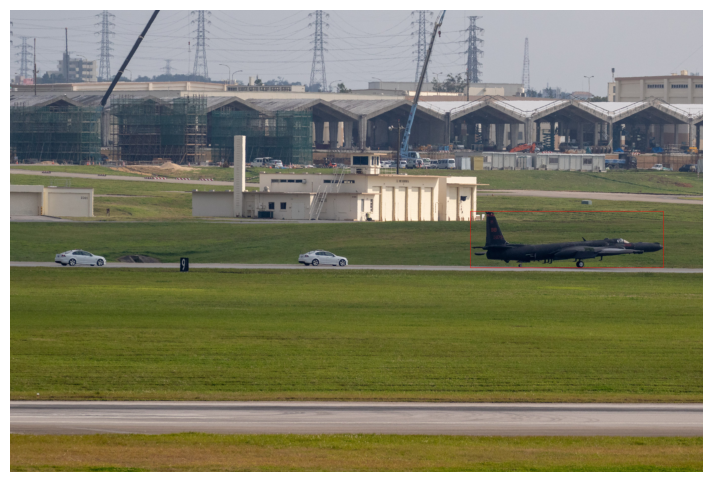

In [10]:
# Colab cell (python)
import cv2, matplotlib.pyplot as plt
from random import choice
import numpy as np

def draw_yolo_boxes(img_path, label_path, class_names=None):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    # convert bgr to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if Path(label_path).exists():
        with open(label_path, 'r') as f:
            lines = f.read().strip().splitlines()
        for ln in lines:
            parts = ln.split()
            if len(parts) >= 5:
                cls = int(parts[0])
                xc, yc, bw, bh = map(float, parts[1:5])
                x1 = int((xc - bw/2)*w)
                y1 = int((yc - bh/2)*h)
                x2 = int((xc + bw/2)*w)
                y2 = int((yc + bh/2)*h)
                cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                label = str(cls) if not class_names else class_names[cls]
                cv2.putText(img, label, (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1)
    return img

sample = choice(train_img)
img = draw_yolo_boxes(sample, ROOT/"train/labels"/(sample.stem + ".txt"))
plt.figure(figsize=(10,6)); plt.imshow(img); plt.axis('off')
print("Shown sample:", sample.name)


In [11]:
# Colab cell (python)
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print("Device count:", torch.cuda.device_count())


Torch version: 2.9.0+cu126
CUDA available: True
Device name: Tesla T4
Device count: 1


In [12]:
# ONE-CELL YOLOv8 TRAINING (Option B, minimal)
from pathlib import Path

# EDIT THIS LINE ONLY → put correct dataset folder path
ROOT = Path("/content/drive/MyDrive/military_object_dataset")

# auto-create minimal YAML
open("/content/data.yaml", "w").write(f"""
train: {ROOT/'train/images'}
val: {ROOT/'val/images'}
test: {ROOT/'test/images'}
nc: 12
names: ['camouflage_soldier','weapon','military_tank','military_truck','military_vehicle','civilian','soldier','civilian_vehicle','military_artillery','trench','military_aircraft','military_warship']
""")

# install ultralytics + import
!pip install ultralytics -q
from ultralytics import YOLO

# train minimal model
model = YOLO("yolov8n.pt")
model.train(data="/content/data.yaml", epochs=5, imgsz=640, batch=8, name="exp_onecell")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1

RuntimeError: Dataset '/content/data.yaml' error ❌ Dataset '/content/data.yaml' images not found, missing path '/content/drive/MyDrive/military_object_dataset/val/images'
Note dataset download directory is '/content/datasets'. You can update this in '/root/.config/Ultralytics/settings.json'

In [ ]:
# Colab cell (python)
# For better accuracy try yolov8s with heavier augmentations / schedule
model = YOLO('yolov8s.pt')
model.train(data='/content/military_dataset.yaml',
            epochs=60,
            imgsz=640,
            batch=12,
            lr0=0.01,
            name='exp_yolov8s_tuned',
            save=True)


In [ ]:
# Colab cell (python)
import shutil, glob, os
exp_dir = sorted(glob.glob('runs/detect/exp*'), key=os.path.getmtime)[-1]
print("Latest experiment folder:", exp_dir)
best_weight = os.path.join(exp_dir, 'weights', 'best.pt')
print("Best weight path:", best_weight)

# Copy best to Drive for safekeeping
dst = "/content/drive/MyDrive/serve_smart/best_weights.pt"
shutil.copy(best_weight, dst)
print("Copied best.pt to", dst)


In [ ]:
# Colab cell (python)
from ultralytics import YOLO
import shutil, os, glob
weight = "/content/drive/MyDrive/serve_smart/best_weights.pt"  # path to best.pt you saved
model = YOLO(weight)

# Predict: save txts and include confidence
res = model.predict(source=str(ROOT/'test/images'), save=True, save_txt=True, save_conf=True, project='preds', name='preds_run')

# Preds labels will be in preds/preds_run/labels/*.txt
labels_dir = '/content/preds/preds_run/labels'
print("Prediction labels saved in:", labels_dir)
print("Example files:", os.listdir(labels_dir)[:10])


In [ ]:
# Colab cell (python)
from pathlib import Path
p = Path(labels_dir)
sample_txt = list(p.glob("*.txt"))[0]
print("Sample txt:", sample_txt.name)
print(sample_txt.read_text()[:400])
# Basic parse test
with open(sample_txt) as f:
    for line in f:
        parts = line.split()
        assert len(parts) >= 6, "Line doesn't have class,x,y,w,h,conf"
print("Sample format OK")


In [ ]:
# Colab cell (python)
import zipfile, os, shutil
preds_folder = "/content/predictions_for_submission"
os.makedirs(preds_folder, exist_ok=True)

# copy all txts
for txt in Path(labels_dir).glob("*.txt"):
    shutil.copy(txt, Path(preds_folder)/txt.name)

# double-check count
n_txt = len(list(Path(preds_folder).glob("*.txt")))
n_imgs = len(list((ROOT/"test/images").glob("*")))
print("txt files:", n_txt, "test images:", n_imgs)

# zip
zip_path = "/content/drive/MyDrive/serve_smart/predictions.zip"
shutil.make_archive(zip_path.replace(".zip",""), 'zip', preds_folder)
print("Zipped predictions to:", zip_path)


In [ ]:
# Colab cell (python)
import matplotlib.pyplot as plt, cv2
from random import sample

test_imgs = list((ROOT/"test/images").glob("*"))
vis_samples = sample(test_imgs, min(5, len(test_imgs)))

for img_path in vis_samples:
    # read image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # read corresponding txt
    txt_path = Path(labels_dir)/ (img_path.stem + ".txt")
    if txt_path.exists():
        with open(txt_path) as f:
            for ln in f:
                parts = ln.split()
                if len(parts) >= 6:
                    cls = int(parts[0]); xc, yc, bw, bh, conf = map(float, parts[1:6])
                    h, w = img.shape[:2]
                    x1 = int((xc - bw/2)*w); y1 = int((yc - bh/2)*h)
                    x2 = int((xc + bw/2)*w); y2 = int((yc + bh/2)*h)
                    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                    cv2.putText(img, f"{cls}:{conf:.2f}", (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0),1)
    plt.figure(figsize=(8,6)); plt.imshow(img); plt.title(img_path.name); plt.axis('off')


In [ ]:
# Colab cell (bash)
# Replace path with your best pt path
!yolo export model=/content/drive/MyDrive/serve_smart/best_weights.pt format=onnx
!yolo export model=/content/drive/MyDrive/serve_smart/best_weights.pt format=torchscript
